In [63]:
import numpy as np
import pandas as pd
import random
import pickle
import csv

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from IPython.display import Image

from datetime import datetime

In [64]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [65]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [66]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [67]:
TRAIN_DATASET_PATH = 'D:/task/train.csv'
TEST_DATASET_PATH = 'D:/task/test.csv'

## Описание задачи
### Цель - предсказать цены на квартиры

## Описание датасета

#### Id - идентификационный номер квартиры
#### DistrictId - идентификационный номер района
#### Rooms - количество комнат
#### Square - площадь
#### LifeSquare - жилая площадь
#### KitchenSquare - площадь кухни
#### Floor - этаж
#### HouseFloor - количество этажей в доме
#### HouseYear - год постройки дома
#### Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
#### Social_1, Social_2, Social_3 - социальные показатели местности
#### Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
#### Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
#### Price - цена квартиры

In [68]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


# EDA

In [69]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [70]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [71]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте:', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте: 5000


In [72]:
train_df.shape[1] - 1 == test_df.shape[1]

True

#### Приведение типов

In [73]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

#### Приведение категориальных данных к строковому типу, чтобы модель не обучалась на них

In [74]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

#### Целевая переменная

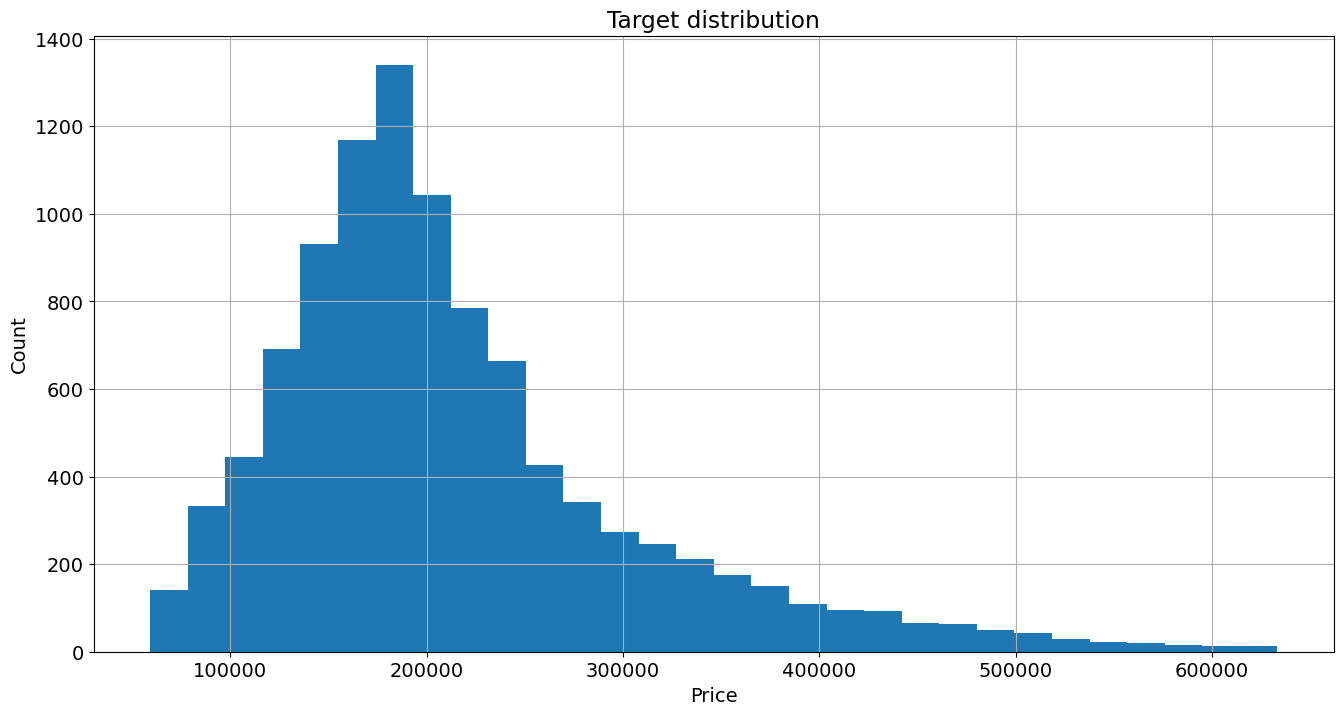

In [76]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

####  Количественные переменные

In [77]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>],
       [<AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>],
       [<AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>],
       [<AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>,
        <AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>]],
      dtype=object)

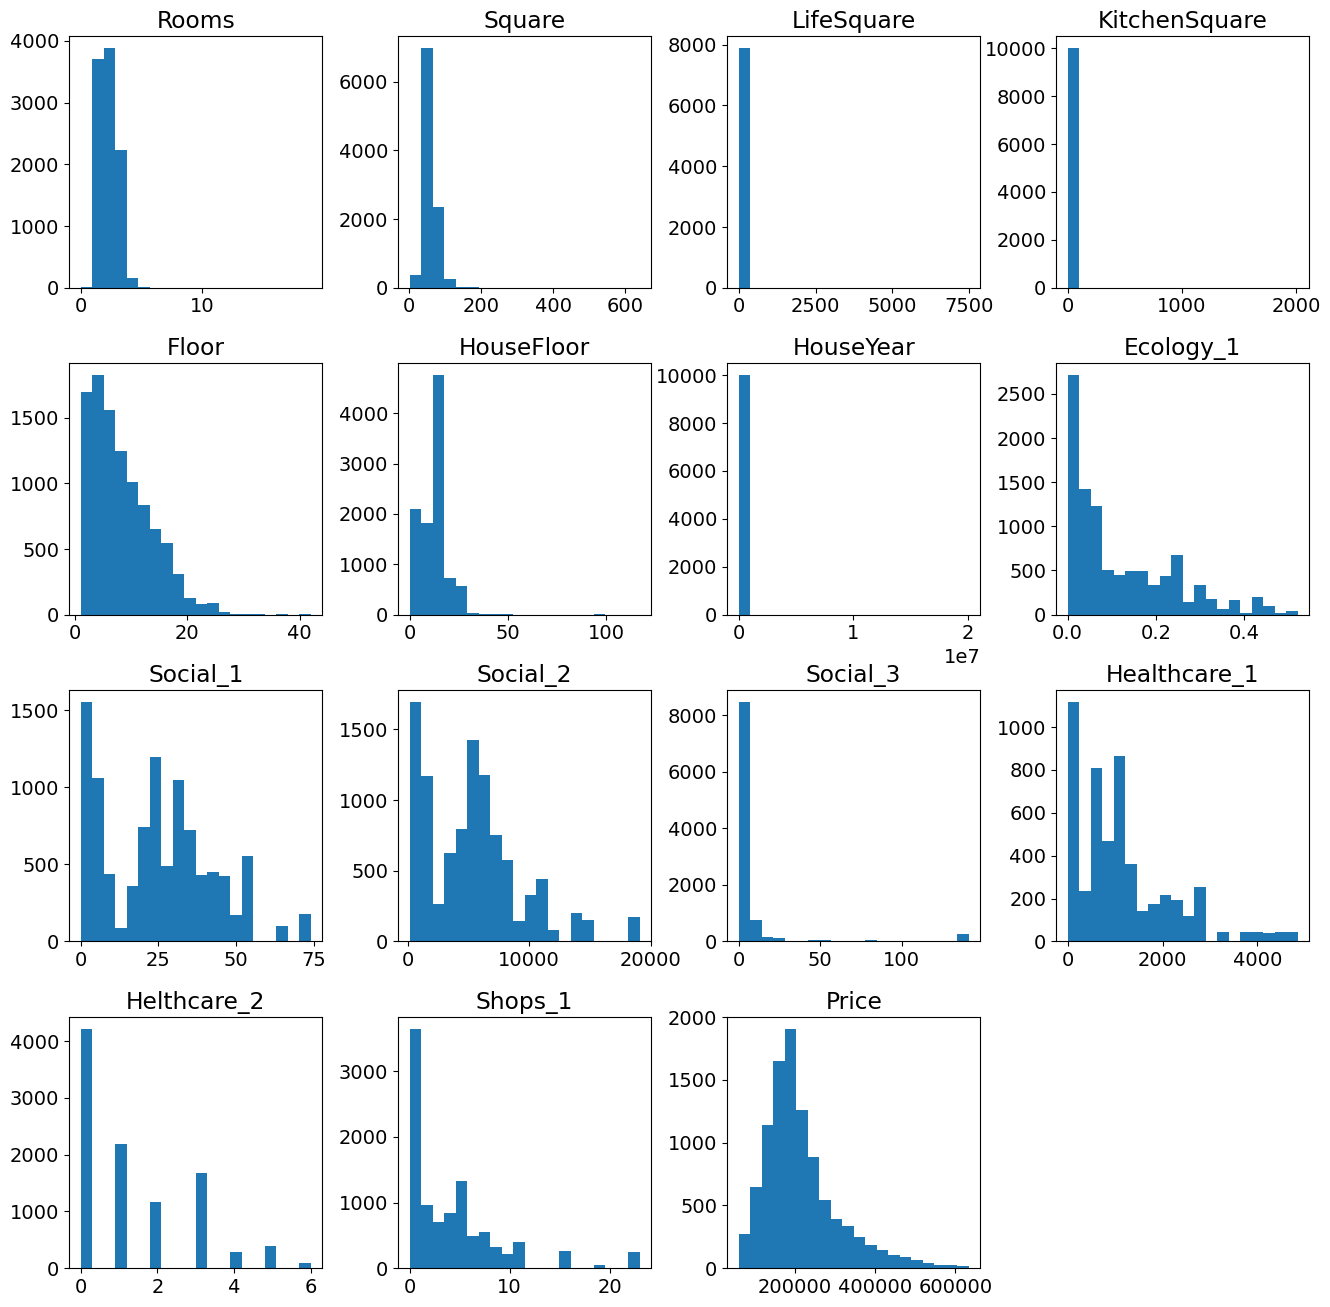

In [78]:
train_df.hist(figsize=(16,16), bins=20, grid=False)

In [79]:
train_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

#### Выведение зависимости  признаков

In [80]:
train_df.corr()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
Rooms,1.000000,0.662893,0.131336,0.005123,-0.000665,-0.029302,-0.010612,-0.032347,0.075980,0.071335,0.012811,0.042857,0.063557,0.053618,0.550291
Square,0.662893,1.000000,0.196129,0.008320,0.114791,0.081505,-0.009032,-0.064479,-0.070690,-0.043120,0.035241,-0.039748,-0.022960,0.021357,0.520075
LifeSquare,0.131336,0.196129,1.000000,-0.001195,0.024559,0.027442,-0.002210,-0.023629,-0.048363,-0.039283,0.012763,-0.026867,-0.024762,-0.007569,0.081292
KitchenSquare,0.005123,0.008320,-0.001195,1.000000,-0.011397,0.000780,0.000958,-0.005622,0.043379,0.037805,-0.015140,0.009472,0.043170,0.010216,0.028864
Floor,-0.000665,0.114791,0.024559,-0.011397,1.000000,0.418986,0.000928,-0.016133,-0.044914,-0.016560,-0.002237,-0.138294,-0.065537,0.024264,0.128715
HouseFloor,-0.029302,0.081505,0.027442,0.000780,0.418986,1.000000,-0.000864,-0.004362,-0.020801,0.007194,-0.008137,-0.143973,-0.068728,0.026279,0.088280
HouseYear,-0.010612,-0.009032,-0.002210,0.000958,0.000928,-0.000864,1.000000,0.001465,0.003026,0.001970,0.000819,-0.011969,0.011245,0.003681,0.004305
Ecology_1,-0.032347,-0.064479,-0.023629,-0.005622,-0.016133,-0.004362,0.001465,1.000000,0.026464,0.009264,-0.124068,-0.043547,0.030873,-0.076749,-0.058381
Social_1,0.075980,-0.070690,-0.048363,0.043379,-0.044914,-0.020801,0.003026,0.026464,1.000000,0.955988,0.023721,0.077133,0.524593,0.526272,0.263286
Social_2,0.071335,-0.043120,-0.039283,0.037805,-0.016560,0.007194,0.001970,0.009264,0.955988,1.000000,0.073379,0.050458,0.473193,0.559163,0.239226


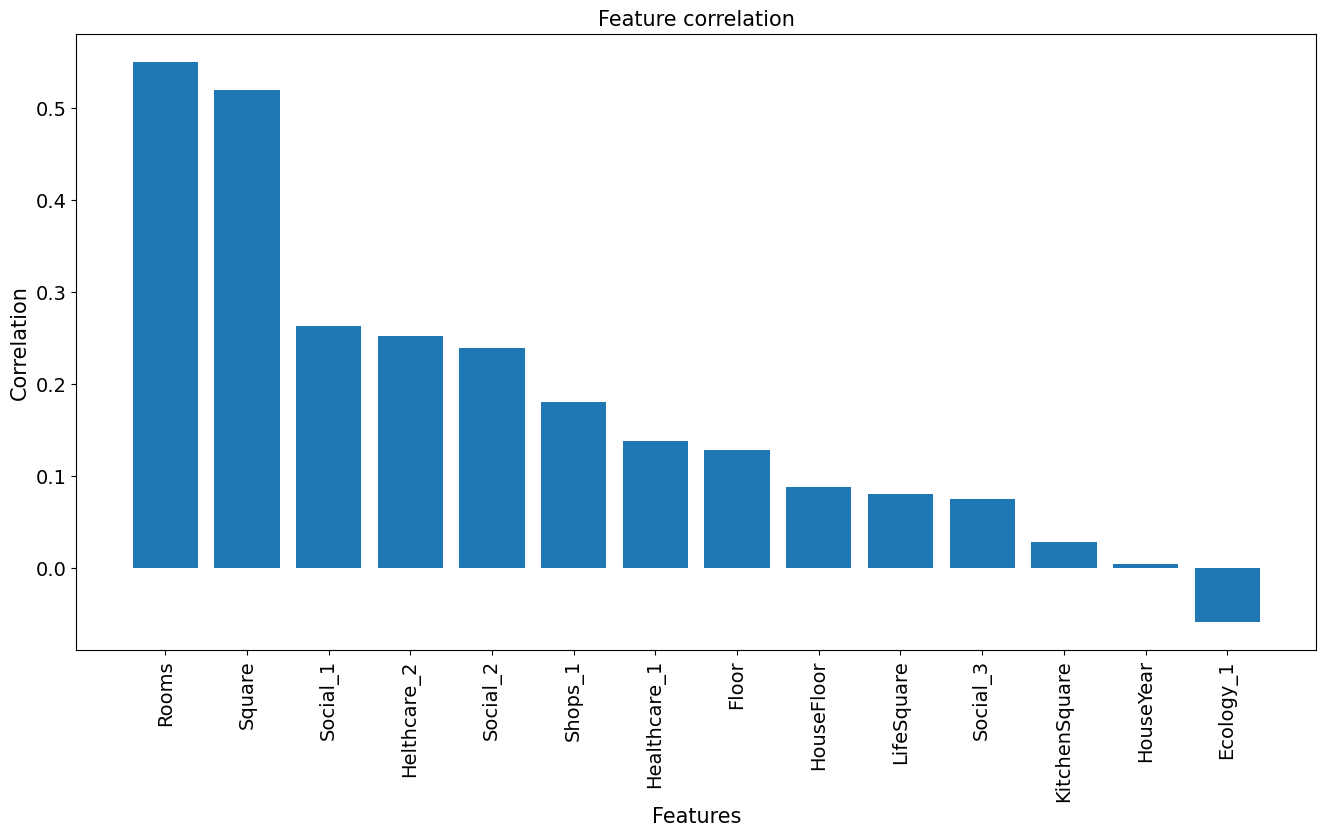

In [81]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

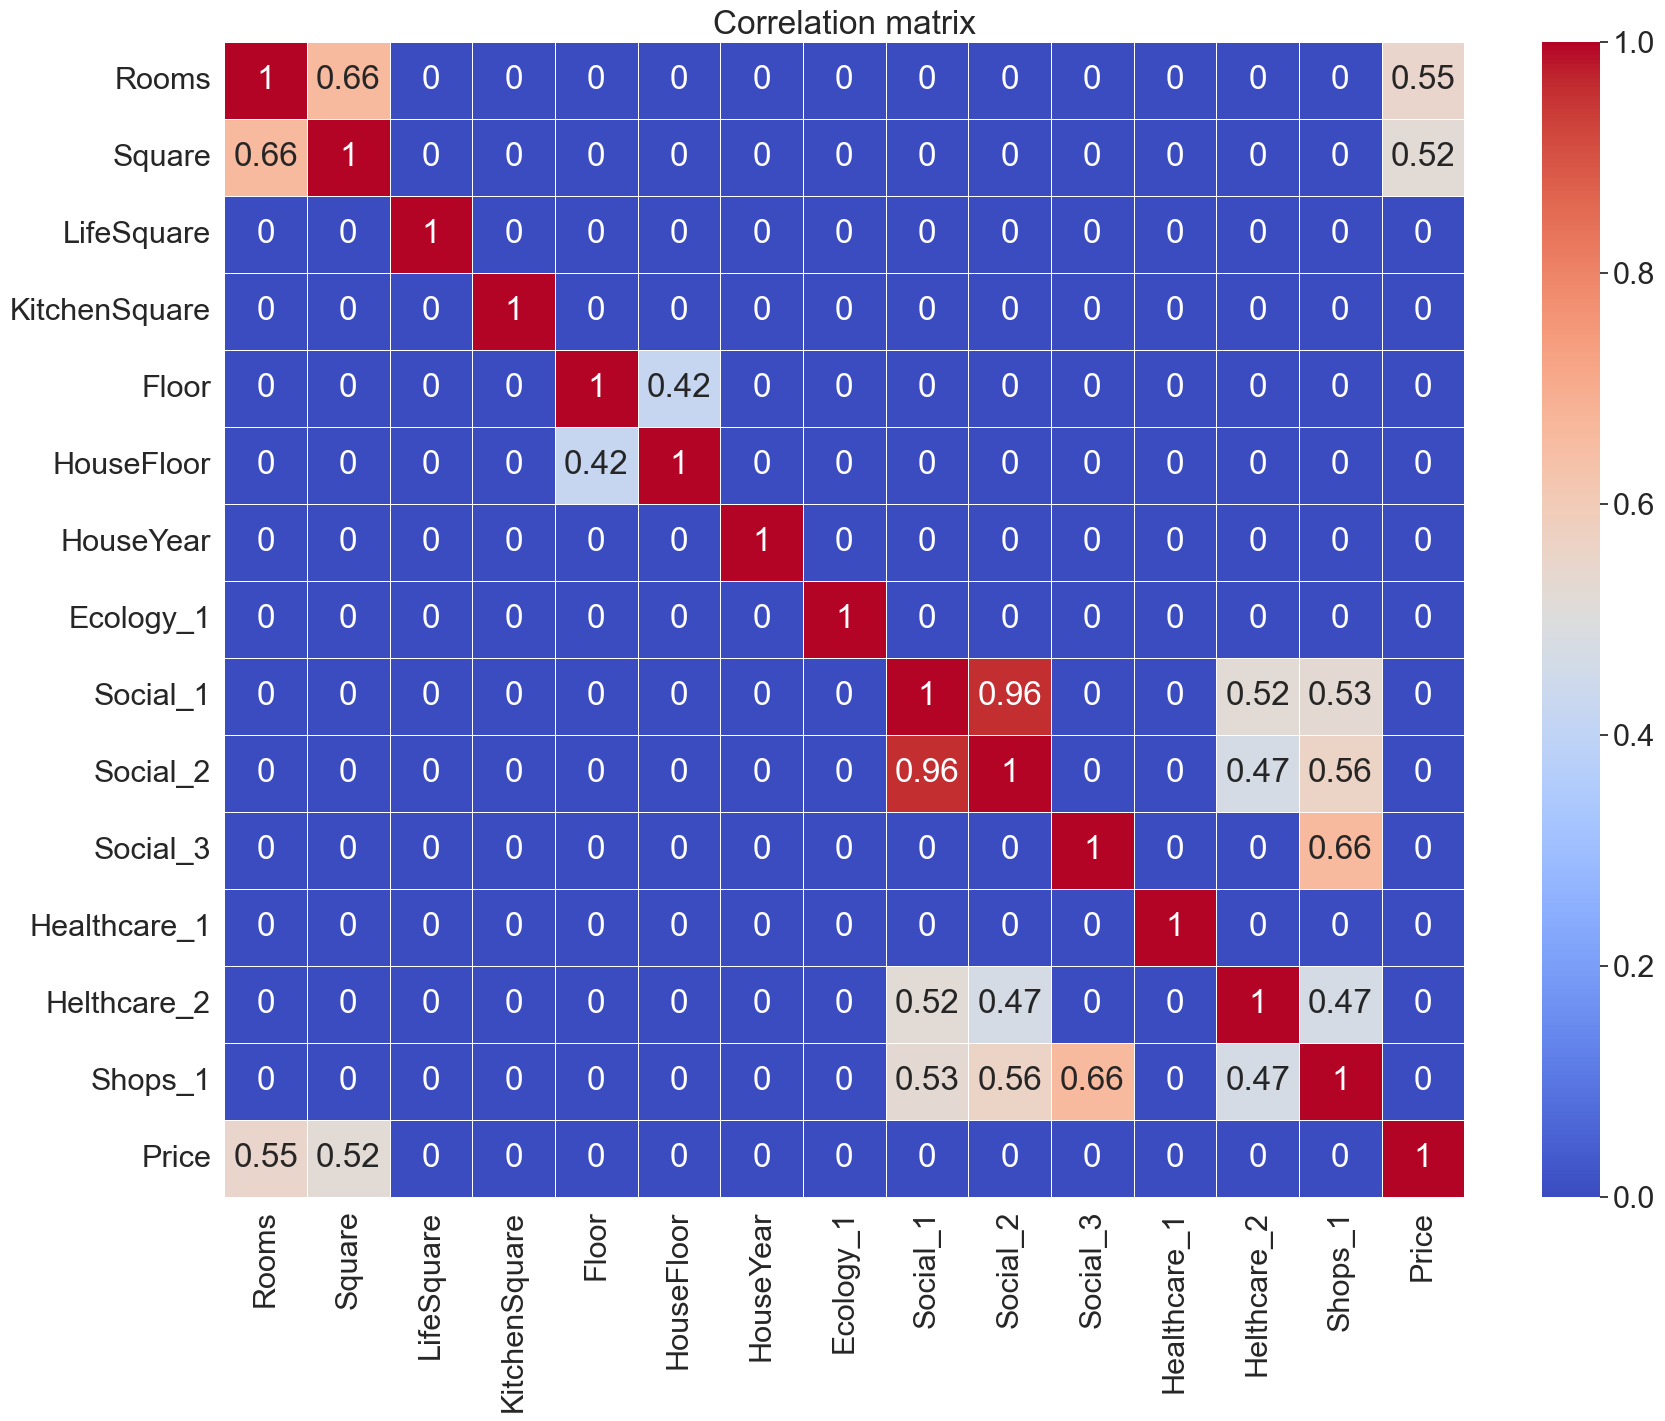

In [82]:
plt.figure(figsize = (20, 15))

sns.set(font_scale=2.0)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, lw=0.5, cmap = 'coolwarm')

plt.title('Correlation matrix')
plt.show()

In [83]:
# Выбросы наблюдаются в: HouseYear, KitchenSquare.Признаки Rooms, KitchenSquare, HouseFloor имеют в некоторых наблюдениях нулевые значения
# Признаки с аномально высоким значением, которые нужно будет ограничить: HouseFloor, LifeSquare, Rooms, Square.

#### Номинативные переменные

In [84]:
df_obj_features = train_df.select_dtypes(include='object')
df_obj_features.head()

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
0,14038,35,B,B,B
1,15053,41,B,B,B
2,4765,53,B,B,B
3,5809,58,B,B,B
4,10783,99,B,B,B


In [85]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
174      1
205      1
209      1
Name: DistrictId, Length: 205, dtype: int64

In [86]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [87]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [88]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка выбросов

##### Rooms

In [89]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [90]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,B,33,7976,5,NaN,0,11,B,184966.930730,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.450063,0
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.908524,0
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.227217,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,B,35,5776,1,2078.0,2,4,B,150226.531644,0


In [91]:
train_df['Rooms_outlier'].value_counts()

0    9988
1      12
Name: Rooms_outlier, dtype: int64

In [92]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [93]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

#### KitchenSquare

In [94]:
train_df['KitchenSquare'].value_counts()


1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
32.0         2
41.0         2
51.0         2
30.0         2
112.0        2
37.0         2
43.0         2
25.0         2
58.0         2
84.0         1
75.0         1
21.0         1
54.0         1
62.0         1
40.0         1
29.0         1
1970.0       1
27.0         1
39.0         1
35.0         1
23.0         1
73.0         1
31.0         1
60.0         1
63.0         1
42.0         1
36.0         1
96.0         1
26.0         1
53.0         1
78.0         1
66.0         1
2014.0       1
48.0         1
72.0         1
123.0        1
Name: KitchenSquare, dtype: int64

<AxesSubplot:xlabel='KitchenSquare'>

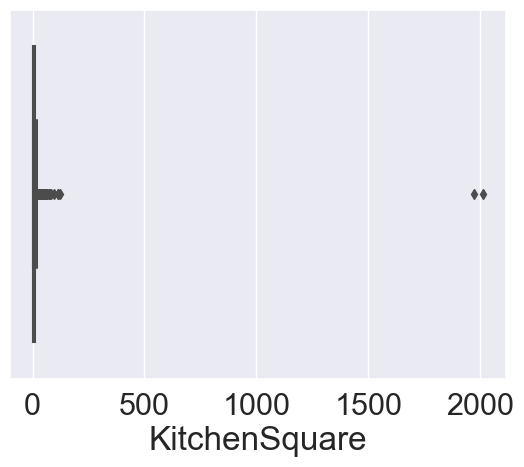

In [95]:
sns.boxplot(train_df.KitchenSquare)

#### Обработка данных площади кухни при помощи квантилей

In [96]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

##### Если площаль кухни больше высшего квантиля = 13, то заменяем на медиану. Если кухня меньше 3, то приравниваем к 3.

In [97]:
condition = (train_df['KitchenSquare'].isna()) | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [98]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

### HouseFloor, Floor
#####  этажность домов и  этаж объектов

In [99]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [100]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [101]:
# Проверим, есть ли объекты, этаж которых больше этажности дома
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [102]:
# объекты, у которых нулевая либо больше 90 этажность дома и этаж объекта больше этажности дома
# заменяем нулевые значения этажности домов на медиану, а этажи выше 90 на 90.

In [103]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [104]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [105]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([   7,   14,   16,   21,   26,   35,   39,   44,   51,   67,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1610)

In [106]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [107]:
(train_df['Floor'] > train_df['HouseFloor']).sum()


0

### HouseYear

In [108]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
5701        2020
2493        2020
1499        2020
          ...   
7611        1916
910         1914
2656        1912
5111        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: int64

In [109]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

## Обработка пропусков

In [110]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

#### LifeSquare
##### пропуски в признаке жилая площадь заполним разностью между общей площадью квартиры и площадью кухни. 

In [111]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,47.981561,29.442751,6.0
1,65.683640,40.049543,8.0
2,44.947953,29.197612,3.0
3,53.352981,52.731512,9.0
4,39.649192,23.776169,7.0
5,80.384479,46.683720,12.0
6,62.254114,37.160377,7.0
7,80.312926,NaN,3.0
8,64.511437,NaN,3.0
9,46.461409,18.915552,8.0


In [112]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) & (~train_df['Square'].isna()) & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] - train_df.loc[condition, 'KitchenSquare'] - 3


In [113]:
train_df.LifeSquare.isna().sum()

0

#### Healthcare_1
##### Признак отсутствует  в 50% выборки, не является информативным, поэтому удаляется.

In [114]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [115]:
train_df.LifeSquare.isna().sum()

0

## Класс обработки данных

In [116]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['HouseFloor'] > 90, 'HouseFloor'] = 90
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

### Построение новых признаков

In [117]:
#  Переведем категориальные признаки в бинарные (экология_1, экология_2, магазины_2)
# binary_to_numbers = {'A': 0, 'B': 1}

binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)
train_df[['Ecology_2', 'Ecology_3', 'Shops_2']].head()

,Ecology_2,Ecology_3,Shops_2
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1


In [118]:
# Добавим частотный признак на основе районов

In [119]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [120]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,0,11,1,184966.930730,0,0,0,22
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,10309,1,1,16,1,300009.450063,0,0,0,87
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,7759,0,1,3,1,220925.908524,0,0,0,174
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5735,3,0,5,1,175616.227217,0,0,0,179
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2,4,1,150226.531644,0,0,0,97


In [121]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [122]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

#### MedPriceByDistrict

In [123]:
# расчитываем среднюю стоимость объекта по районам и количеству комнат.
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head(10)

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126
5,1,3.0,244005.272380
6,1,4.0,277290.705058
7,10,1.0,167742.760878
8,10,2.0,217749.656911
9,10,3.0,267667.016108


In [124]:
med_price_by_district.shape

(667, 3)

In [125]:
# добавляем новый признак в датасет.
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,1,184966.930730,0,0,0,22,0,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,16,1,300009.450063,0,0,0,87,0,300009.450063
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,1,3,1,220925.908524,0,0,0,174,1,263206.223152
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,0,5,1,175616.227217,0,0,0,179,1,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,1,150226.531644,0,0,0,97,0,158539.052715


####  MedPriceByFloorYear
##### новый признак, определяющий стоимость квартиры в зависимости от этажа и года постройки.

In [126]:
# разбиваем признаки на категории
def floor_to_cat(X):
        bins = [0, 3, 5, 9, 15, X['Floor'].max()]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
def year_to_cat(X):
        bins = [0, 1941, 1950, 1980, 2000, 2010, 2015, X['HouseYear'].max()]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

In [127]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       2
1       2
2       2
3       2
4       3
       ..
9995    0
9996    3
9997    3
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [128]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0        (5, 9]
1        (5, 9]
2        (5, 9]
3        (5, 9]
4       (9, 15]
         ...   
9995     (0, 3]
9996    (9, 15]
9997    (9, 15]
9998     (0, 3]
9999     (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64, right]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [129]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,1,184966.930730,0,0,0,22,0,207786.135836,2,2
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,300009.450063,0,0,0,87,0,300009.450063,2,2
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,1,220925.908524,0,0,0,174,1,263206.223152,2,2
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,1,175616.227217,0,0,0,179,1,166809.665642,2,2
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,150226.531644,0,0,0,97,0,158539.052715,2,3


In [130]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,0,0,362698.813373
1,0,1,324303.812481
2,0,2,429458.388683
3,0,3,274992.472366
4,1,0,409215.676844


In [131]:
# добавляем новый признак в датасет.
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,184966.930730,0,0,0,22,0,207786.135836,2,2,192658.547447
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,300009.450063,0,0,0,87,0,300009.450063,2,2,192658.547447
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,220925.908524,0,0,0,174,1,263206.223152,2,2,192658.547447
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,175616.227217,0,0,0,179,1,166809.665642,2,2,192658.547447
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,150226.531644,0,0,0,97,0,158539.052715,2,3,183469.921382


In [132]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.district_size = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.floor_max = None
       
        self.house_year_max = None
        self.house_year_min = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
           
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
        
        
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, X['Floor'].max()]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1950, 1980, 2000, 2010, 2015, X['HouseYear'].max()]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X   
        
        
        
        return X


## Отбор признаков

In [133]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [134]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'MedPriceByDistrict', 'IsDistrictLarge', 'MedPriceByFloorYear', 'year_cat', 'floor_cat']

target_name = 'Price'

In [135]:
train_df.corr()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
Rooms,1.000000,0.688022,0.156890,0.125324,-0.010023,-0.038485,-0.044113,-0.030992,-0.002393,-0.006715,...,0.571514,-0.023678,0.000999,-0.068380,-0.100487,-0.081656,0.698256,-0.033386,-0.012665,0.095207
Square,0.688022,1.000000,0.242872,0.074427,0.086664,0.104173,0.179489,-0.064479,0.029926,0.022748,...,0.520075,0.027231,0.061666,0.099227,0.051798,0.060945,0.476234,0.152636,0.072863,0.067980
LifeSquare,0.156890,0.242872,1.000000,-0.068291,0.023252,0.030515,0.044990,-0.029652,0.010433,0.016112,...,0.084300,0.009449,0.024306,0.088004,0.079221,0.069817,0.076490,0.044413,0.018098,-0.040000
KitchenSquare,0.125324,0.074427,-0.068291,1.000000,0.118055,0.164671,0.212233,0.026335,0.003690,-0.060282,...,0.297115,-0.012257,-0.213143,-0.521402,-0.327805,-0.336143,0.264961,0.193664,0.131783,0.432120
Floor,-0.010023,0.086664,0.023252,0.118055,1.000000,0.626993,0.264607,-0.003771,0.043399,0.014904,...,0.103844,0.000596,-0.262904,0.073849,0.081601,0.075242,0.008646,0.190675,0.942558,0.244817
HouseFloor,-0.038485,0.104173,0.030515,0.164671,0.626993,1.000000,0.396672,-0.019938,0.067781,0.018863,...,0.087143,-0.007401,-0.356224,0.129546,0.139753,0.132815,-0.027021,0.281026,0.604196,0.177418
HouseYear,-0.044113,0.179489,0.044990,0.212233,0.264607,0.396672,1.000000,-0.065987,0.076826,0.047215,...,0.036735,0.014043,-0.037777,-0.088955,0.201515,0.198405,-0.074534,0.934264,0.256058,0.058669
Ecology_1,-0.030992,-0.064479,-0.029652,0.026335,-0.003771,-0.019938,-0.065987,1.000000,-0.110725,-0.223197,...,-0.058381,0.002016,-0.033863,-0.059470,-0.172966,0.007485,-0.059783,-0.056406,-0.000534,0.018291
Ecology_2,-0.002393,0.029926,0.010433,0.003690,0.043399,0.067781,0.076826,-0.110725,1.000000,-0.016643,...,0.022379,0.003430,0.007139,0.036231,0.054421,0.067692,0.024870,0.048395,0.045347,0.014276
Ecology_3,-0.006715,0.022748,0.016112,-0.060282,0.014904,0.018863,0.047215,-0.223197,-0.016643,1.000000,...,-0.052585,0.005829,0.014545,0.087039,0.106924,0.093441,-0.058737,0.030455,0.017502,-0.037442


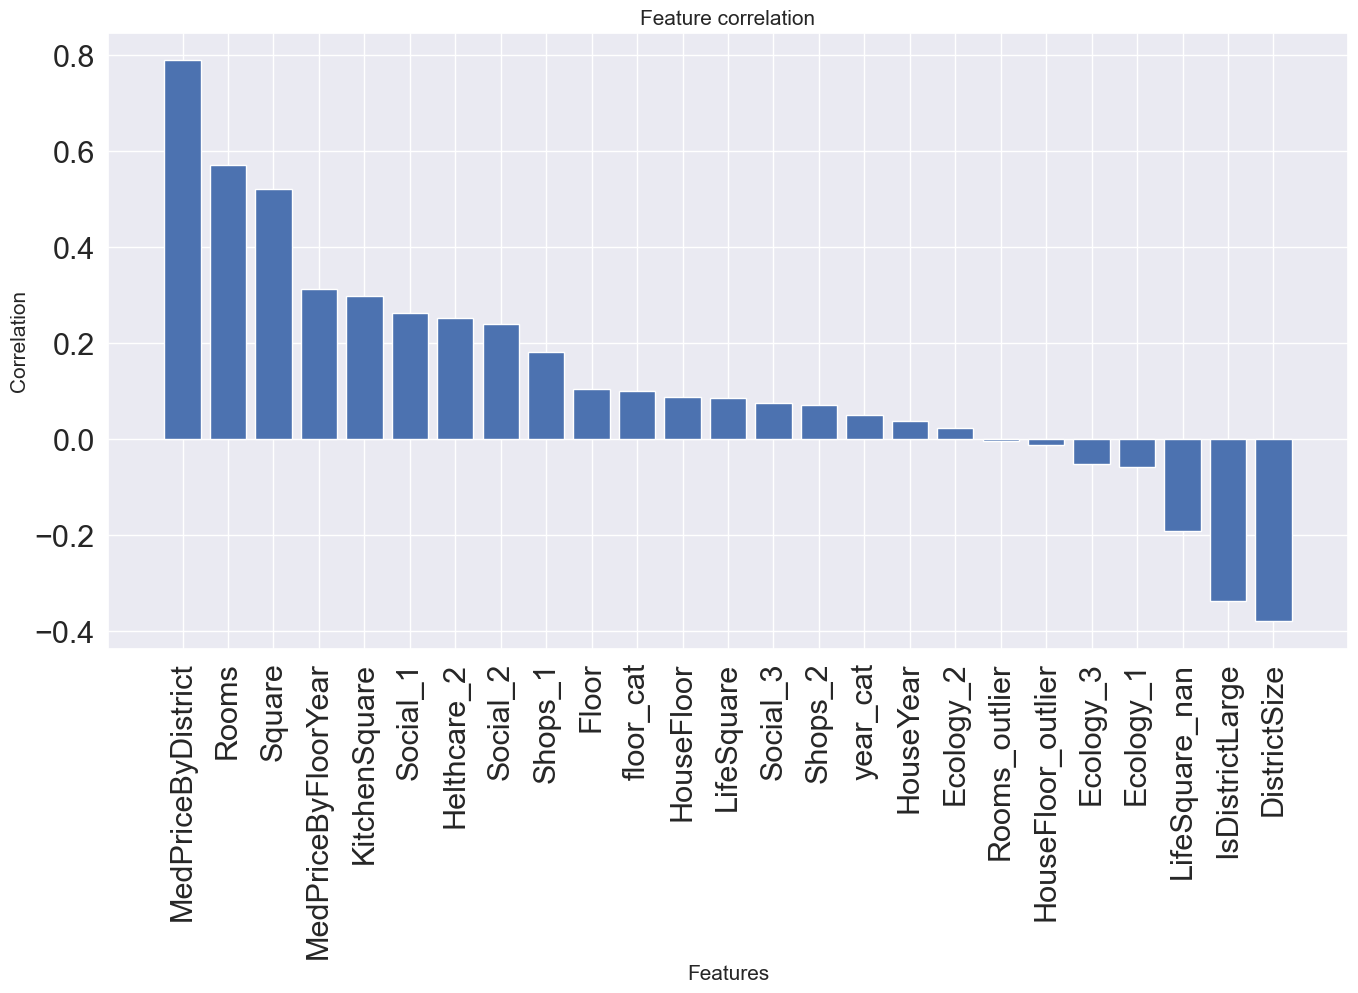

In [136]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

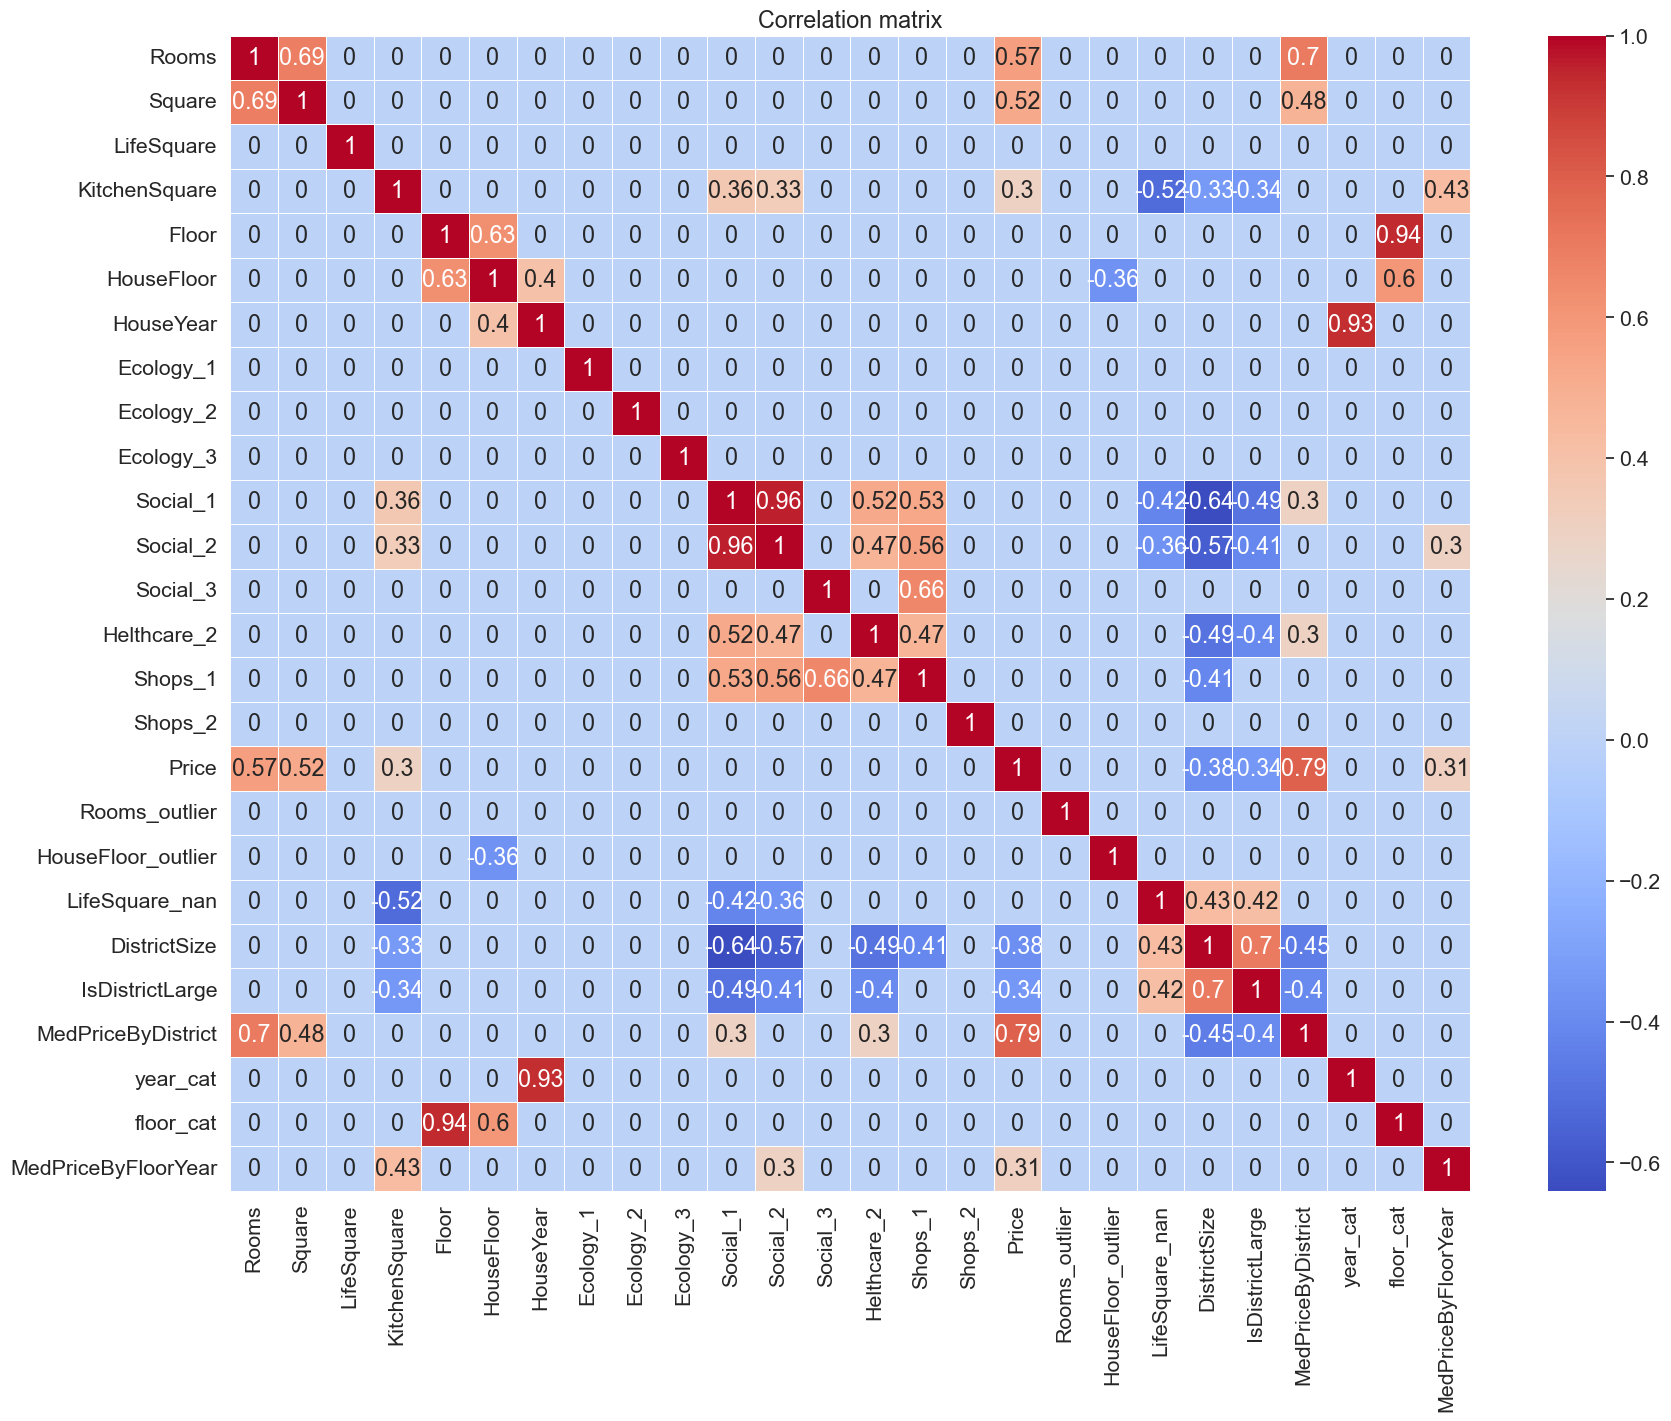

In [137]:
plt.figure(figsize = (20, 15))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, lw=0.5, cmap = 'coolwarm')

plt.title('Correlation matrix')
plt.show()

# Разбиваем на тренировочные и тестовые

In [138]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [139]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [140]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [141]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 29), (3300, 29), (5000, 29))

In [142]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [143]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

# Построение модели

### Обучение модели

#### RandomForestRegressor

In [144]:
rf_model = RandomForestRegressor(random_state=21, criterion='squared_error')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

### Оценка модели

Train R2:	0.965
Test R2:	0.706


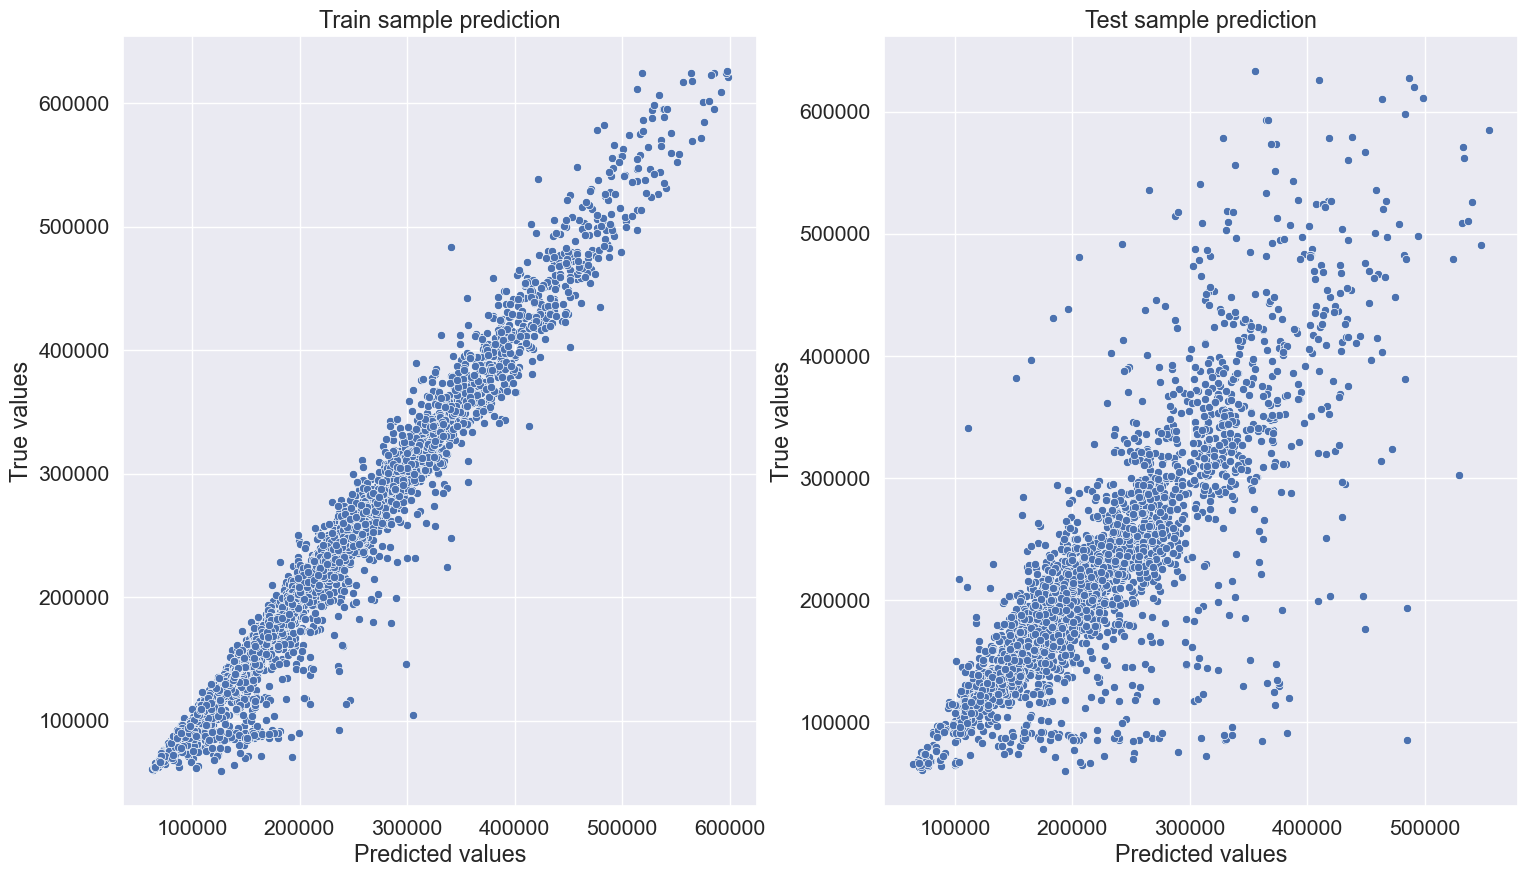

In [145]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Кросс-валидация

In [146]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.73057737, 0.74385353, 0.76494556])

In [147]:
cv_score.mean()

0.7464588224825265

In [148]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
21,MedPriceByDistrict,0.628535
1,Square,0.120739
2,LifeSquare,0.030117
20,DistrictSize,0.026694
5,HouseFloor,0.024197
6,HouseYear,0.021432
12,Social_3,0.021292
23,MedPriceByFloorYear,0.020294
3,KitchenSquare,0.017647
4,Floor,0.015928


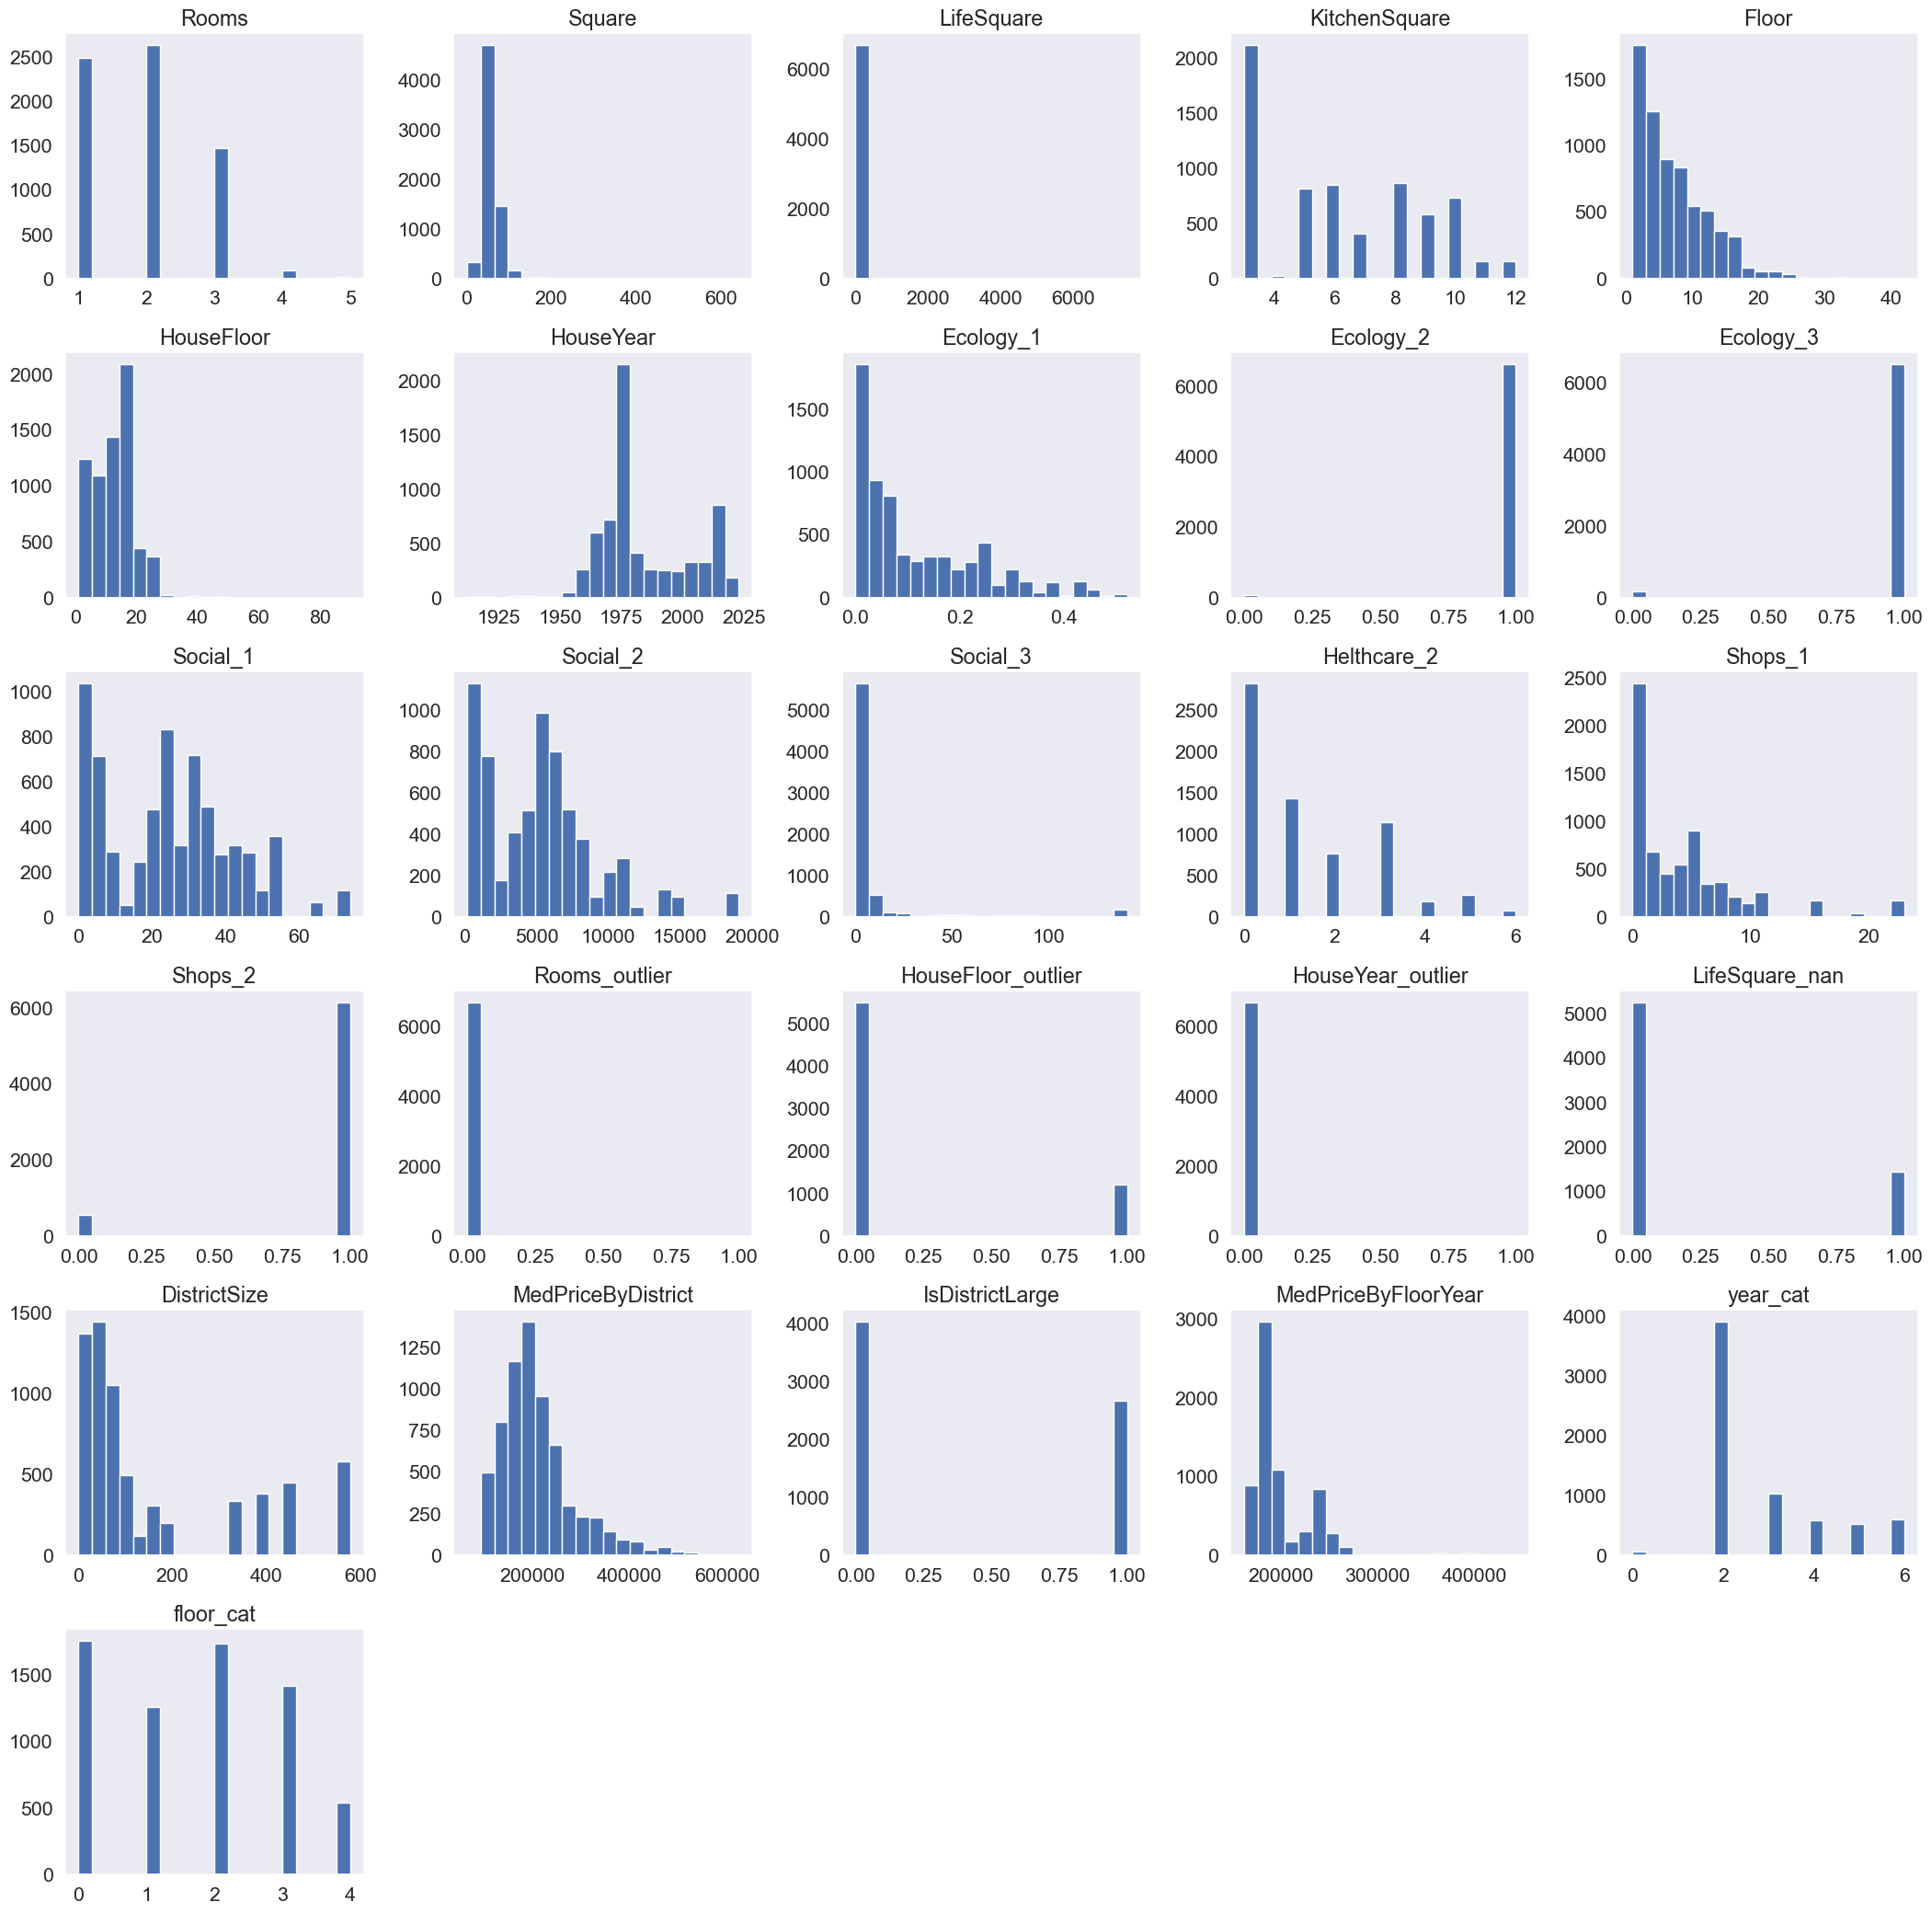

In [149]:
X_train.hist(figsize=(26,26), bins=20, grid=False);

### Линейная регрессия

In [150]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)
             


LinearRegression()

Train R2:	0.699
Test R2:	0.565


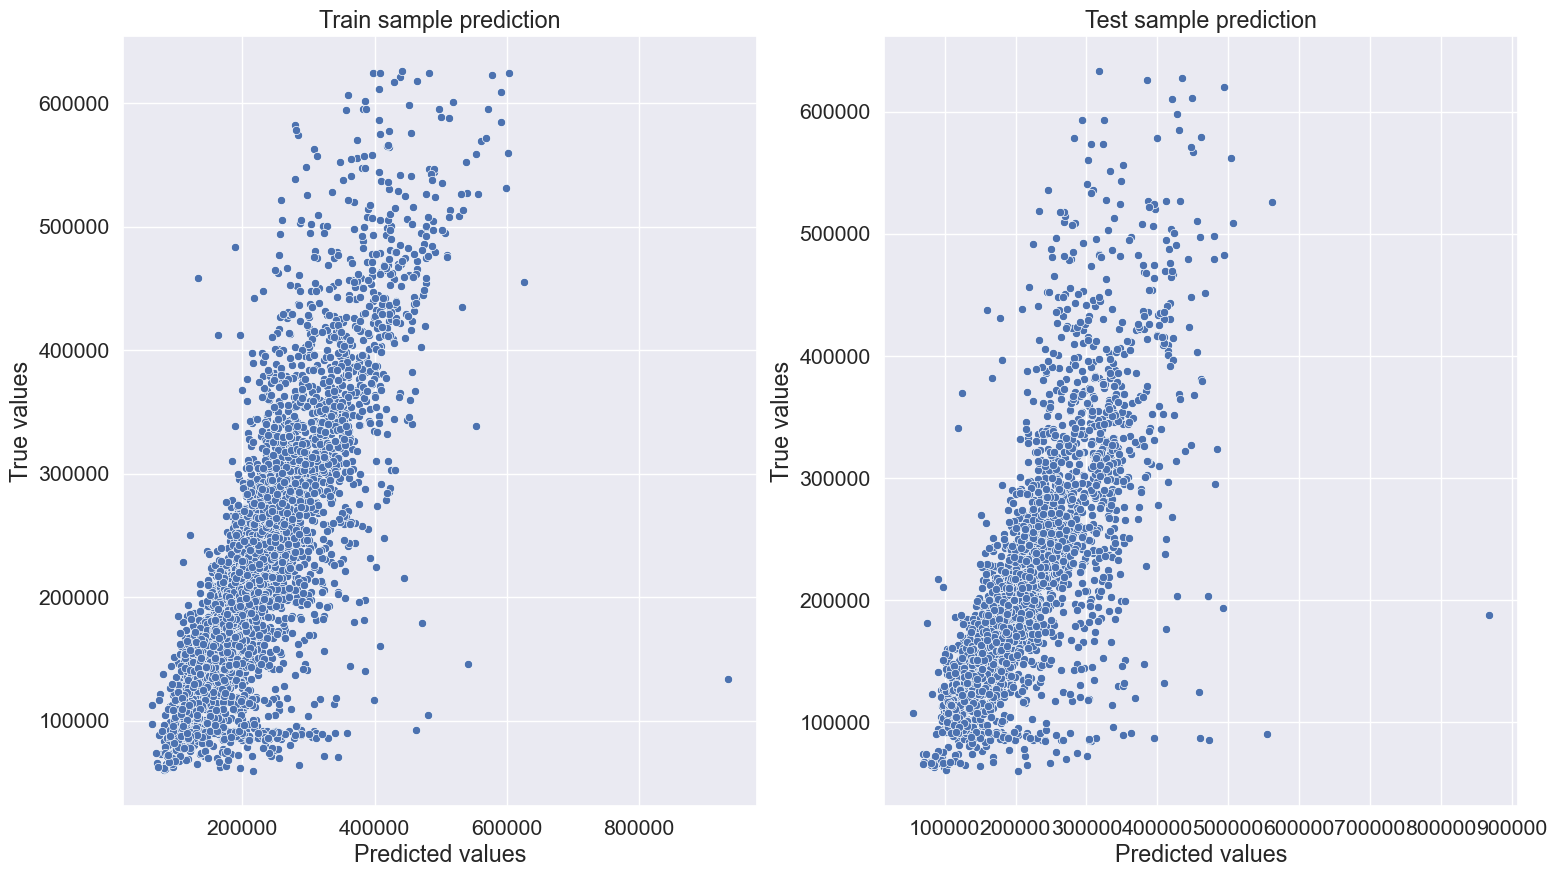

In [151]:
y_train_preds = lr_model.predict(X_train)
y_test_preds = lr_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### CatBoost

In [152]:
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train, y_train)

GradientBoostingRegressor()

Train R2:	0.802
Test R2:	0.676


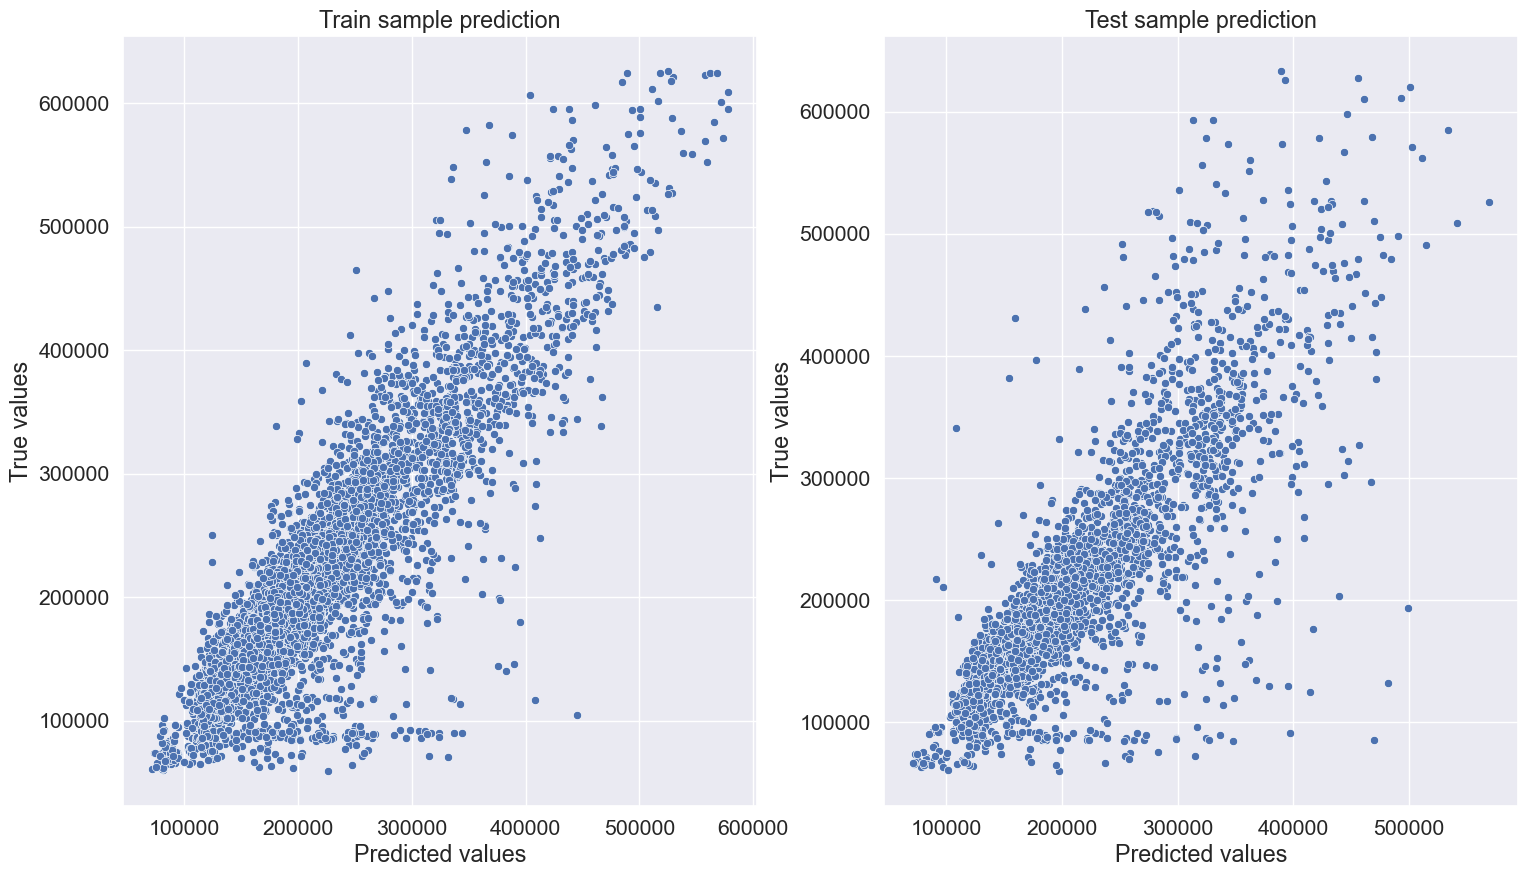

In [153]:
y_train_preds = gbr_model.predict(X_train)
y_test_preds = gbr_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

## Прогнозирование на тестовом датасете

In [154]:
test_df.shape

(5000, 26)

In [155]:
predictions = rf_model.predict(test_df)
predictions

array([153073.47233638, 213743.72915232, 236089.52921199, ...,
       323609.84861547, 197952.47422528, 156354.1909692 ])

In [162]:
with open('predictions', 'wb') as file:
    pickle.dump(predictions, file)

In [163]:
filename = 'T_Pochkareva_predictions.csv'

In [164]:
fields = ['Price']

In [165]:
dict = {'Price': predictions}

In [166]:
df = pd.DataFrame(dict)
print(df)

              Price
0     153073.472336
1     213743.729152
2     236089.529212
3     317376.569262
4     142998.905127
...             ...
4995  249361.112750
4996  135599.760741
4997  323609.848615
4998  197952.474225
4999  156354.190969

[5000 rows x 1 columns]


In [167]:
df.to_csv(filename)

In [159]:
with open('rf_final_model', 'wb') as file:
    pickle.dump(rf_model, file)

In [160]:
with open('preprocessor_model', 'wb') as file:
    pickle.dump(preprocessor, file)